In [4]:
# !wget 'http://ufldl.stanford.edu/housenumbers/train.tar.gz'
# !tar xvf train.tar.gz

--2019-09-29 05:45:17--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  23.6MB/s    in 18s     

2019-09-29 05:45:35 (21.9 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

train/
train/4804.png
train/4777.png
train/4759.png
train/4750.png
train/4727.png
train/4722.png
train/4698.png
train/4685.png
train/4655.png
train/4621.png
train/4527.png
train/4496.png
train/4492.png
train/4437.png
train/4394.png
train/4388.png
train/4380.png
train/4377.png
train/4325.png
train/4312.png
train/4298.png
train/4182.png
train/4145.png
train/4140.png
train/4090.png
train/4078.png
train/4034.png
train/4009.png
train/3996.png
train/3957.png
train/3934.png
train/3919.png
train/

### Read the .mat file into a usable format

In [0]:
!git clone https://github.com/prijip/Py-Gsvhn-DigitStruct-Reader.git

Cloning into 'Py-Gsvhn-DigitStruct-Reader'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), done.


In [0]:
%cd Py-Gsvhn-DigitStruct-Reader/
!python digitStructMatToCsv.py ../extra/digitStruct.mat ../ocr.csv

/content/Py-Gsvhn-DigitStruct-Reader
Converting ../extra/digitStruct.mat to ../ocr.csv
Number of image files: 202353


In [0]:
% cd .. 

/content


### Look at data

In [1]:
from fastai.vision import *
from fastai.text import *

In [2]:
images = get_image_files('extra')

In [3]:
train_df = pd.read_csv('extra_ocr.csv')

In [4]:
train_df.head()

,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,4,24,70,38,56
1,1.png,7,55,41,36,56
2,1.png,8,79,23,47,56
3,2.png,7,32,13,94,203
4,2.png,1,143,33,38,203


In [5]:
labelled_df = train_df.groupby('FileName').apply(lambda x: ''.join([str(i) for i in x['DigitLabel']])).to_frame().reset_index(0)
labelled_df.columns = ['filename','labels']


In [6]:
labels = labelled_df['labels'].tolist()
labels_clean = []

for label in labels:
    label = str(label)
    idx = label.find('0')
    if idx != -1:
        if label[idx-1] == '1':
            label = label[:idx-1]+label[idx:]
    labels_clean += [int(label)]

In [7]:
labelled_df['labels'] = labels_clean

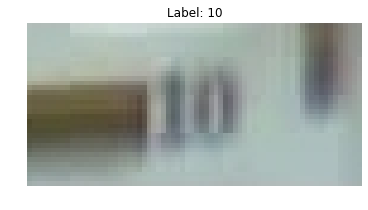

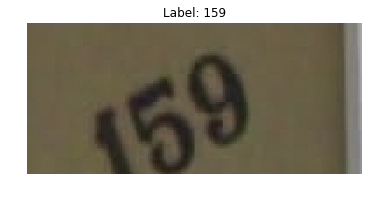

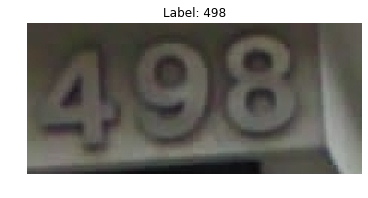

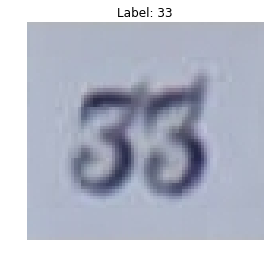

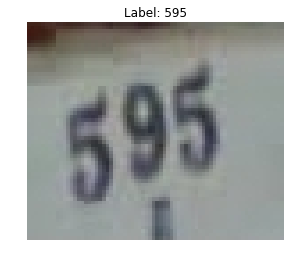

In [8]:
for i in range(5):
    _, ax = plt.subplots()
    name = images[i].name
    im = open_image(images[i])
    im.show(figsize=(6,6), ax=ax)
    ax.set_title('Label: ' + str(labelled_df.loc[labelled_df['filename'] == name]['labels'].item()))

In [27]:
src = ImageList.from_folder('extra').split_by_rand_pct(0.1,seed=42)

train_names = [items.name for items in src.train.items]
val_names = [items.name for items in src.valid.items]


train_order = {v:k for k,v in enumerate(train_names)}
val_order = {v:k for k,v in enumerate(val_names)}

train_df = labelled_df[labelled_df['filename'].isin(train_names)]
valid_df = labelled_df[labelled_df['filename'].isin(val_names)]

train_df['order'] = train_df['filename'].apply(train_order.__getitem__)
train_df = train_df.sort_values('order')

valid_df['order'] = valid_df['filename'].apply(val_order.__getitem__)
valid_df = valid_df.sort_values('order')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [29]:
class OCRTokenizer(BaseTokenizer):
    def __init__(self,lang=None):
        pass
    def tokenizer(self,t):
        bos = t[:5]
        eos = t[-5:]
        t = t[5:-5]
        return [bos] + [char for char in t] + [eos]

In [30]:
bs = 2
val_bs = 2

tok_pre_rules = []
tok_post_rules = []

tok = Tokenizer(tok_func=OCRTokenizer, pre_rules=tok_pre_rules, post_rules=tok_post_rules)

procs = [TokenizeProcessor(tokenizer=tok, include_bos=True, include_eos=True), 
            NumericalizeProcessor(min_freq=1)]

In [31]:
path = './'

In [32]:
label_train_il = TextList.from_df(train_df, path=path, cols=['labels'], processor=procs).process()

In [33]:
label_valid_il = TextList.from_df(valid_df, path=path, cols=['labels'], processor=procs).process()

In [34]:
trn_ll = LabelList(src.train, label_train_il)
val_ll = LabelList(src.valid, label_valid_il)

lls = LabelLists(path, train=trn_ll, valid=val_ll)

In [35]:
def ocr_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        include_targets=True, include_lengths=True, include_masks=True,
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    c,h,w = samples[0][0].shape
    samples.sort(key=lambda x: len(x[1]), reverse=True)
    
    y_lens = [len(s[1]) for s in samples]
    y_max_len = max(y_lens)
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    x_res = torch.zeros(len(samples),c,h,w).float()
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            y_res[i,:len(s[1]):] = LongTensor(s[1])
        x_res[i,:] = tensor(s[0])
        
    x = [x_res]
    
    return x_res, y_res


In [36]:
data = ImageDataBunch.create_from_ll(lls,size=(48,100),collate_fn=ocr_pad_collate,bs=200).normalize(imagenet_stats)

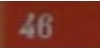

In [39]:
data.valid_ds[120][0]

In [40]:
data.valid_ds[120][1]

Text xxbos   4 6   xxeos

### Define architecture

In [42]:
class ExperimentalBidirRNN(nn.Module):
    def __init__(self, nIn=256, nHidden=256):
        super().__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)

    def forward(self, input):
        seq_len, bs, _ = input.shape
        recurrent, _ = self.rnn(input)
        recurrent = recurrent.view(seq_len, bs, 2, -1)
        fwd = recurrent[:,:,0,:]
        bwd = recurrent[:,:,1,:]
        return fwd+bwd
    
class CnnFeatureExtractor(nn.Module):
    def __init__(self, ndim=256, nout=64):
        super().__init__()    
        layers = [conv_layer(ni=3,nf=8, ks=(3,3), padding=0),
        conv_layer(ni=8,nf=32, ks=(3,3), padding=0),
        nn.MaxPool2d(3,2,1),
        conv_layer(ni=32,nf=64, ks=(3,3), padding=0),
        nn.MaxPool2d(3,2,1)]

        self.cnn = nn.Sequential(*layers)
        self.rnn = nn.Sequential(
            ExperimentalBidirRNN(64),
            ExperimentalBidirRNN(),
            ExperimentalBidirRNN()
        )
        
        self.final_conv = nn.Conv1d(ndim,nout,1)
    def forward(self,x):
        features = self.cnn(x)
        
        #TODO: Try max instead of mean
        features = features.mean(-2).squeeze(-2).permute(2,0,1)
        
        features = self.rnn(features)
        features = self.final_conv(features.permute(1,2,0)).permute(2,0,1)
        
        return features

In [43]:
class AttentionDecoder(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        # test
        self.vat = nn.Linear(hidden_size, 1)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)        
        embedded = self.dropout(embedded)

        # test
        batch_size = encoder_outputs.shape[1]
        alpha = hidden + encoder_outputs        
        alpha = alpha.contiguous().view(-1, alpha.shape[-1])
        attn_weights = self.vat( torch.tanh(alpha))                     
        attn_weights = attn_weights.view(-1, 1, batch_size).permute((2,1,0))
        attn_weights = F.softmax(attn_weights, dim=2)

        attn_applied = torch.matmul(attn_weights,
                                 encoder_outputs.permute((1, 0, 2)))     
        
        try:
          output = torch.cat((embedded, attn_applied.squeeze(1) ), 1) 
        except:
          output = torch.cat((embedded.unsqueeze(0), attn_applied.squeeze(1) ), 1) 

        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        ## index into 0 to remove the first dim (it is 1)
        logits = self.out(output) #output logits
        return logits, hidden, attn_weights

    def initHidden(self, batch_size):
        result = Variable(torch.zeros(1, batch_size, self.hidden_size))

        return result
      
class Decoder(nn.Module):
    def __init__(self, nh=256, nclass=13, dropout_p=0.1, teacher_forcing=0.75, max_len=15, pad_idx=1, bos_idx=2):
        super().__init__()
        self.hidden_size = nh
        self.decoder = AttentionDecoder(nh, nclass, dropout_p)
        self.teacher_forcing = 0.5
        self.max_len = max_len
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
    def forward(self, encoded_images, target=None): 
        bs = encoded_images.shape[1]
        decoder_hidden = self.initHidden(bs).cuda()
        decoder_input = encoded_images.new_zeros(bs).long() + self.bos_idx  
        
        outputs = []
        
        for i in range(1, self.max_len):  
            decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoded_images)
            outputs += [decoder_output]

            _, topi = decoder_output.data.topk(1)
            decoder_input = topi.squeeze()
            if (decoder_input==self.pad_idx).all(): break
            if (target is not None) and (random.random()<self.teacher_forcing):
                if i>=target.shape[1]-1: 
                    break
                decoder_input = target[:,i]

              
        return torch.cat(outputs,0).permute(1,0,2)

    def initHidden(self, batch_size):
        result = torch.zeros(1, batch_size, self.hidden_size)
        return result

In [44]:
class OCRModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.encoder = CnnFeatureExtractor()
        self.decoder = Decoder(64, 24, dropout_p=0.1)
   
      def forward(self,input, target=None):
        encoded = self.encoder(input)
        output = self.decoder(encoded, target)

        return output

In [45]:
def OCR_loss(out, targ, pad_idx=1):
    targ = targ[:,1:]
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [46]:
def OCR_acc(out, targ, pad_idx=1):
    targ = targ[:,1:]
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(-1)
    return (out==targ).float().mean()

In [47]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - 0.5 * epoch/self.end_epoch

In [48]:
model = OCRModel().cuda()
learn = Learner(data,model,loss_func=OCR_loss, metrics=[OCR_acc],callback_fns=partial(TeacherForcing, end_epoch=8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


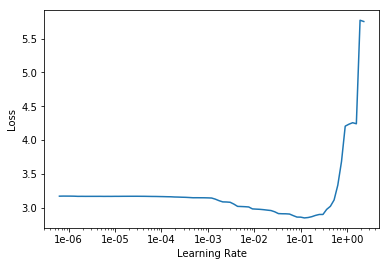

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,OCR_acc,time
0,1.453860,2.020293,0.320288,01:42
1,0.847886,0.912188,0.690386,01:44
2,0.434642,0.483650,0.822834,01:46
3,0.180474,0.209660,0.941324,01:46
4,0.118633,0.160810,0.956444,01:46
5,0.094838,0.123370,0.966191,01:46
6,0.070045,0.113737,0.969325,01:46
7,0.059768,0.100440,0.971455,01:46
8,0.048808,0.101850,0.972283,01:47
9,0.042674,0.102797,0.972666,01:46


In [ ]:
learn.save('ocr-1')

In [179]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,OCR_acc,time
0,1.102703,1.718533,0.437104,00:19
1,1.102866,1.690963,0.441879,00:19
2,1.037347,1.689088,0.443087,00:19
3,1.077144,1.675130,0.438468,00:19
4,0.963829,1.405220,0.526695,00:19


In [0]:
learn.save('ocr-2')

In [180]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,OCR_acc,time
0,0.956121,1.327603,0.548471,00:19
1,0.964401,1.655489,0.442846,00:19
2,0.964874,1.631282,0.448738,00:19
3,0.948462,1.214629,0.582335,00:19
4,0.883365,1.203199,0.584121,00:19
5,0.866533,0.958321,0.671519,00:19
6,0.829903,0.982670,0.663142,00:19
7,0.811939,1.034316,0.641023,00:19
8,0.806363,0.979918,0.658987,00:18
9,0.815273,0.932013,0.673177,00:19


In [0]:
learn.save('ocr-3')

In [181]:
learn.fit_one_cycle(30,1e-3)

epoch,train_loss,valid_loss,OCR_acc,time
0,0.818061,0.937664,0.672861,00:19
1,0.811002,0.967226,0.659591,00:19
2,0.792947,1.122524,0.607218,00:18
3,0.795662,1.141393,0.607057,00:18
4,0.808709,0.859772,0.696033,00:19
5,0.773412,0.866911,0.692702,00:18
6,0.779032,0.840306,0.704154,00:19
7,0.767491,0.837846,0.714933,00:19
8,0.743912,0.773045,0.736153,00:19
9,0.681776,0.818294,0.710704,00:19


In [182]:
learn.fit_one_cycle(15,5e-4)

epoch,train_loss,valid_loss,OCR_acc,time
0,0.248348,0.494326,0.856986,00:18
1,0.252090,0.502517,0.856786,00:18
2,0.261279,0.517667,0.853426,00:18
3,0.262187,0.515009,0.852699,00:18
4,0.254054,0.491248,0.856336,00:18
5,0.240339,0.493296,0.858762,00:18
6,0.220810,0.498291,0.861963,00:18
7,0.207943,0.505112,0.862400,00:18
8,0.188317,0.537788,0.860042,00:19
9,0.171398,0.520948,0.865174,00:18


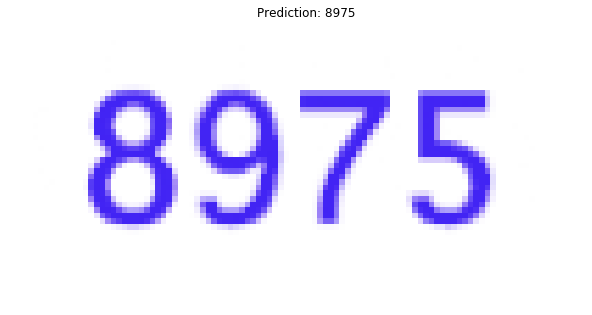

In [68]:
_ , ax = plt.subplots(figsize=(10,10))
x = open_image('numbres2.png')
x = x.resize((3,48,100))
input = normalize(x.data,tensor(imagenet_stats[0]),tensor(imagenet_stats[1])).unsqueeze(0)
res = learn.model(input.cuda())
outs = [data.train_ds.vocab.itos[i] for i in res.argmax(-1)[0]]
x.show(ax=ax)

to_print = ''
for char in outs:
  if char in ['0','1','2','3','4','5','6','7','8','9']:
    to_print += char
ax.title.set_text(f'Prediction: {to_print}')

In [52]:
def get_preds(num_preds, rows=2):
  start = np.random.randint(len(data.valid_ds)-num_preds)
  
  dim = num_preds // rows 
  if num_preds % rows != 0:
    dim += 1
  _ , axs = plt.subplots(dim,rows, figsize=(10,10))
  axs = axs.flatten()  
  for i in range(num_preds):
    x,_= data.valid_ds[start+i]
    input = normalize(x.data,tensor(imagenet_stats[0]),tensor(imagenet_stats[1])).unsqueeze(0)
    res = learn.model(input.cuda())
    outs = [data.train_ds.vocab.itos[i] for i in res.argmax(-1)[0]]
    x.show(ax=axs[i])
    to_print = ''
    for char in outs:
      if char in ['0','1','2','3','4','5','6','7','8','9']:
        to_print += char
    axs[i].title.set_text(f'Prediction: {to_print}')
    

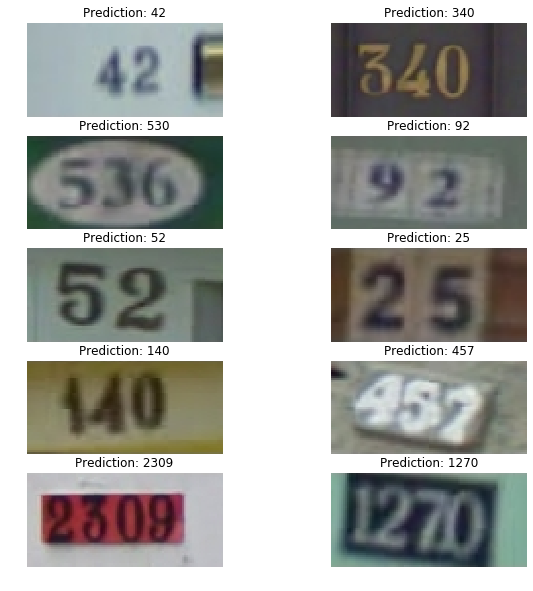

In [54]:
get_preds(10)

In [69]:
data.train_ds.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ' ',
 '1',
 '2',
 '3',
 '5',
 '4',
 '0',
 '7',
 '6',
 '8',
 '9',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake']

In [ ]:
with open('resnet18_itos.pkl','rb') as f:
pickle